In [30]:
import findspark
findspark.init()
import pyspark
import pandas as pd
import csv
import random
from faker import Faker
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division 
from pyspark.sql import SQLContext
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import DenseVector


In [2]:
conf = pyspark.SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '4G')
        .set('spark.driver.maxResultSize', '10G'))
sc = pyspark.SparkContext(conf=conf)

In [801]:
min_value = 0
max_value = 100
x = np.random.uniform(min_value, max_value, 10000)
def generate_normal_dist_random():
    return round(x[np.random.choice(len(x), size=15, replace=False)].mean())
print (generate_normal_dist_random())

44.0


In [802]:
%%time
#https://faker.readthedocs.io/en/latest/providers/faker.providers.address.html

mu, sigma = 50, 0.1

def create_test_data(use_rnd=True):
    f=Faker('en_US') 
    g=open("students_scores.csv","w")
    w=csv.writer(g)
    w.writerow(('id','first_name','last_name','score'))
    
    
    for call_line in range(250):
        #print(call_line)
        score = None
        if use_rnd:
            score = random.randrange(min_value,max_value,1)
        else:
            score = generate_normal_dist_random()
            #score = np.random.normal(mu, sigma, 1)[0]
        region = f.state_abbr()
        first_name = f.first_name()
        last_name = f.last_name()
        w.writerow((call_line,
                        first_name,
                        last_name,
                        score))
    g.close()
create_test_data(False)

CPU times: user 296 ms, sys: 4 ms, total: 300 ms
Wall time: 301 ms


In [803]:
dfpd = pd.read_csv('students_scores.csv')
dfpd.head()

,id,first_name,last_name,score
0,0,Lynn,Wright,68.0
1,1,Mia,Ramirez,52.0
2,2,Cassandra,Wilson,45.0
3,3,Cameron,Wood,36.0
4,4,Michelle,Thomas,45.0


## Read the data

In [804]:
%%time


sqlContext = SQLContext(sc)

#read CSV
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('students_scores.csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 54.6 ms


In [805]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- score: double (nullable = true)



In [806]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df.show()
df_with_vectors = df.select(
    df["id"], 
    list_to_vector_udf(df["score"]).alias("score")
)

+---+----------+---------+-----+
| id|first_name|last_name|score|
+---+----------+---------+-----+
|  0|      Lynn|   Wright| 68.0|
|  1|       Mia|  Ramirez| 52.0|
|  2| Cassandra|   Wilson| 45.0|
|  3|   Cameron|     Wood| 36.0|
|  4|  Michelle|   Thomas| 45.0|
|  5|      Tami|   Flores| 64.0|
|  6|      Sean|    Brown| 47.0|
|  7| Elizabeth|    Reyes| 62.0|
|  8|    Taylor|       Li| 55.0|
|  9|    Thomas|  Russell| 53.0|
| 10|   Chelsea|    Kirby| 46.0|
| 11|      Mark|   Hardin| 56.0|
| 12|   Rebecca|  Michael| 44.0|
| 13|    Amanda| Williams| 54.0|
| 14|   Matthew|   Benson| 47.0|
| 15|    Cheryl|   Barnes| 43.0|
| 16| Alexander|   Murphy| 48.0|
| 17|   Natasha| Williams| 61.0|
| 18|     Kelly|     Cole| 52.0|
| 19|    Justin| Lawrence| 47.0|
+---+----------+---------+-----+
only showing top 20 rows



In [807]:
df_with_vectors.show()

+---+------+
| id| score|
+---+------+
|  0|[68.0]|
|  1|[52.0]|
|  2|[45.0]|
|  3|[36.0]|
|  4|[45.0]|
|  5|[64.0]|
|  6|[47.0]|
|  7|[62.0]|
|  8|[55.0]|
|  9|[53.0]|
| 10|[46.0]|
| 11|[56.0]|
| 12|[44.0]|
| 13|[54.0]|
| 14|[47.0]|
| 15|[43.0]|
| 16|[48.0]|
| 17|[61.0]|
| 18|[52.0]|
| 19|[47.0]|
+---+------+
only showing top 20 rows



In [808]:


mvv_list = df_with_vectors.select('score').collect()
normal_dist = DenseVector(np.random.normal(mu, sigma, len(mvv_list)))
uniform_dist = DenseVector(np.random.uniform(min_value, max_value,len(mvv_list)))
print('Test with uniform')
observed = DenseVector(mvv_list)
r = Statistics.chiSqTest(observed, uniform_dist)
print(r)

print('***'*20)
print('Test with normal')
r = Statistics.chiSqTest(observed, normal_dist)
print(r)


Test with uniform
Chi squared test summary:
method: pearson
degrees of freedom = 249 
statistic = 52205.7401617117 
pValue = 0.0 
Very strong presumption against null hypothesis: observed follows the same distribution as expected..
************************************************************
Test with normal
Chi squared test summary:
method: pearson
degrees of freedom = 249 
statistic = 258.95049771794726 
pValue = 0.31922421904977616 
No presumption against null hypothesis: observed follows the same distribution as expected..


In [809]:
df_with_vectors.printSchema()

root
 |-- id: integer (nullable = true)
 |-- score: vector (nullable = true)



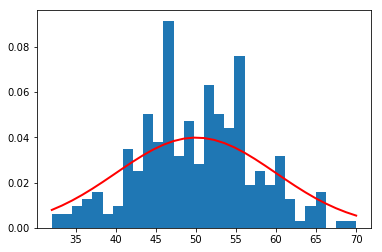

In [810]:

count, bins, ignored = plt.hist(dfpd['score'], 30, normed=True)
#plt.show()

variance = np.square(sigma)
f = np.exp(-np.square(bins-mu)/2*variance)/(np.sqrt(2*np.pi*variance))/max_value
plt.plot(bins,f, linewidth=2, color='r')

plt.show()